In [1]:
! pip install noise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp310-cp310-linux_x86_64.whl size=56273 sha256=c21809e426418c31df345b8d4948e834449a80b1673fb7725e416b5d020fe4b2
  Stored in directory: /root/.cache/pip/wheels/b2/01/64/ca2f6ed556c204d5ce2d3719a58757a5504aeb5525654692d0
Successfully built noise


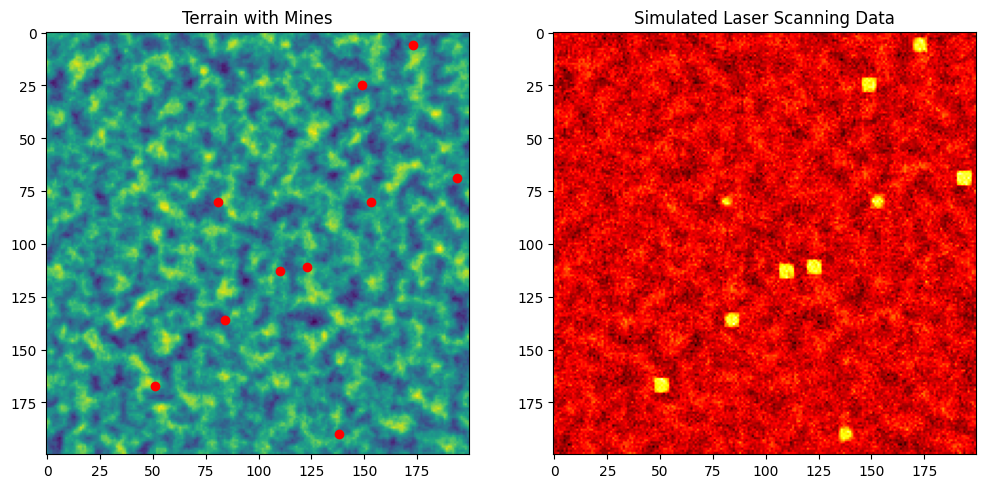

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from noise import pnoise2

def generate_terrain(size, scale=0.1, octaves=6, persistence=0.5, lacunarity=2.0):
    terrain = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            terrain[i, j] = pnoise2(i * scale, j * scale, octaves=octaves,
                                    persistence=persistence, lacunarity=lacunarity, repeatx=size, repeaty=size)
    terrain = (terrain - np.min(terrain)) / (np.max(terrain) - np.min(terrain))  # Normalize to 0-1
    return terrain

def place_mines(terrain, num_mines, max_depth=10):
    mines = []
    size = terrain.shape[0]
    for _ in range(num_mines):
        x, y = np.random.randint(0, size, 2)
        depth = np.random.rand() * max_depth
        mines.append((x, y, depth))
    return mines

def simulate_laser_scanning(terrain, mines, size, laser_power=1.0, beam_width=3, noise_level=0.1):
    scanned_data = np.copy(terrain) * 0.5  # Base level of terrain reflectivity
    for x, y, depth in mines:
        for i in range(-beam_width, beam_width + 1):
            for j in range(-beam_width, beam_width + 1):
                if 0 <= x + i < size and 0 <= y + j < size:
                    increment = (laser_power * depth) / (1 + i**2 + j**2)
                    scanned_data[x + i, y + j] += increment

    # Normalize and add Gaussian noise
    scanned_data = np.clip(scanned_data, 0, 1)  # Clip to keep within 0-1 range
    scanned_data += np.random.normal(0, noise_level, (size, size))

    return scanned_data

# Using the functions to generate terrain and mines
size = 200
terrain = generate_terrain(size)
mines = place_mines(terrain, 10)  # Increase the number of mines for better visualization
scanned_data = simulate_laser_scanning(terrain, mines, size)

# Visualizing the terrain with mines and the simulated laser scanning data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(terrain, cmap='viridis')
ax1.set_title('Terrain with Mines')
for x, y, _ in mines:
    ax1.plot(y, x, 'ro')  # Plot mines

ax2.imshow(scanned_data, cmap='hot')
ax2.set_title('Simulated Laser Scanning Data')
plt.show()

<ipython-input-17-6afe7fc8cee4>:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axs[i].plot(frequencies, off_mine_response, 'k--', label='Laser off Mine', color='black')


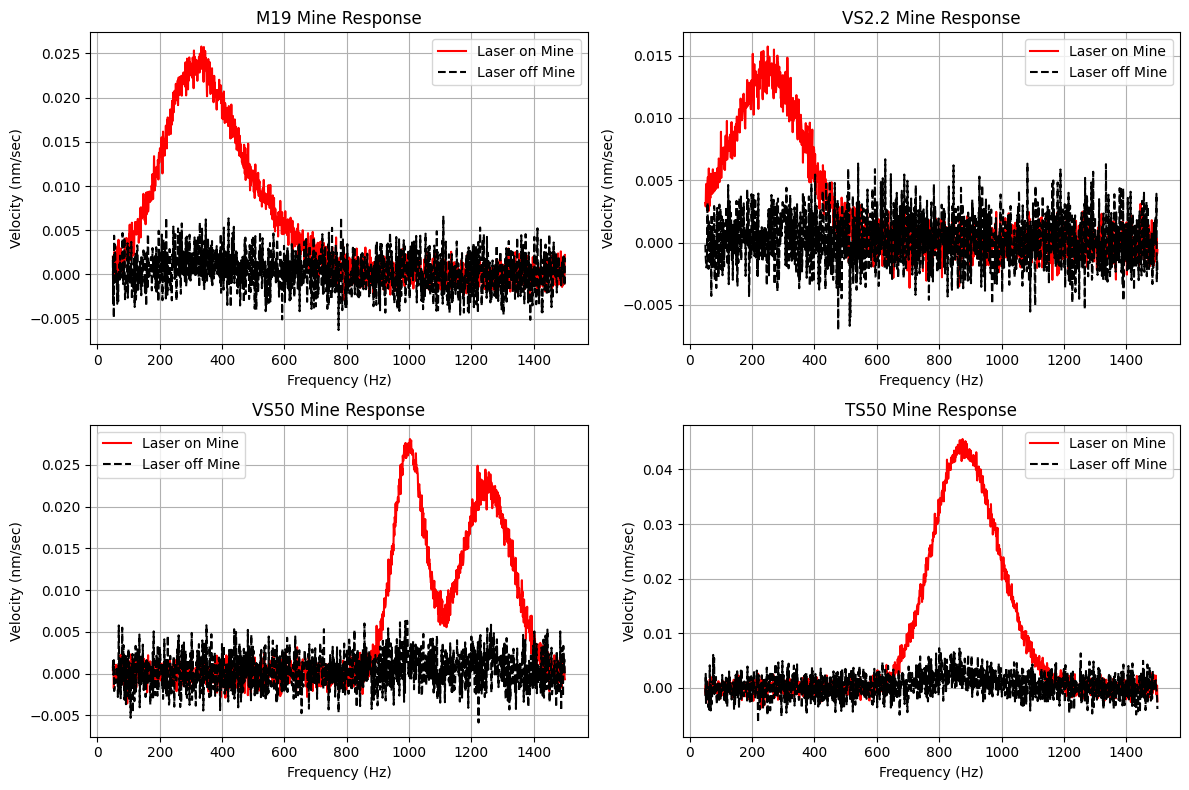

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_seismic_response(frequencies, mine_info, soil_impact):
    """
    Simulates the seismic response considering complex resonance and soil interactions.
    """
    response = np.zeros_like(frequencies)
    for info in mine_info:
        resonance_freq, intrinsic_amplitude, intrinsic_width = info
        affected_amplitude = intrinsic_amplitude * (1 - soil_impact)
        response += affected_amplitude * np.exp(-((frequencies - resonance_freq) ** 2) / (2 * intrinsic_width ** 2))
    return response

def add_environmental_noise(signal, noise_level):
    """
    Adds environmental noise that might affect laser vibrometer readings.
    """
    return signal + np.random.normal(0, noise_level, len(signal))

# Frequency range
frequencies = np.linspace(50, 1500, 1451)

# Mine characteristics: [resonance frequency, amplitude, width]
mine_characteristics = {
    'M19': [(300, 0.02, 100), (450, 0.01, 150)],
    'VS2.2': [(250, 0.015, 120)],
    'VS50': [(1000, 0.03, 50), (1250, 0.025, 80)],
    'TS50': [(850, 0.035, 90), (950, 0.02, 100)]
}

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, (mine, characteristics) in enumerate(mine_characteristics.items()):
    on_mine_response = simulate_seismic_response(frequencies, characteristics, soil_impact=0.1)
    off_mine_response = simulate_seismic_response(frequencies, [(freq, amp*0.1, width) for freq, amp, width in characteristics], soil_impact=0.5)

    on_mine_response = add_environmental_noise(on_mine_response, noise_level=0.001)
    off_mine_response = add_environmental_noise(off_mine_response, noise_level=0.002)

    axs[i].plot(frequencies, on_mine_response, label='Laser on Mine', color='red')
    axs[i].plot(frequencies, off_mine_response, 'k--', label='Laser off Mine', color='black')
    axs[i].set_title(f'{mine} Mine Response')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Velocity (nm/sec)')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()